In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [4]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/nCars_train_EST_trilinear_", transform=transforms)
test_data = NCarsImageDataset("./Datasety/nCars_test_EST_trilinear_", transform=transforms)



In [5]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
from torch import nn

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.relu(out, inplace=False)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 80, start_factor=1.0, end_factor=0.01, total_iters=70):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_ReLU_ReLUmaxpool_EST_FC2__128x128_pretrained_aug_correct_trilinear.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [8]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 12).to("cuda")


In [9]:
model_resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, mo

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
print(model)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

### Copy of a weights

In [12]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): Batc

In [13]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8192e-01]

In [14]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

In [15]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90) #, learning_rate=5e-4

100%|██████████| 482/482 [01:07<00:00,  7.11it/s]


Epoch [1/120], Step [482/482], Loss: 2.1627, Accuracy: 0.6398
Accuracy of the network: 73.10328802137795 Loss: 0.5438959520988748%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [2/120], Step [482/482], Loss: 0.4031, Accuracy: 0.8203
Accuracy of the network: 74.59044963401882 Loss: 0.6726916467833253%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [3/120], Step [482/482], Loss: 0.3589, Accuracy: 0.8454
Accuracy of the network: 81.57313814337168 Loss: 0.43150866663145754%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [4/120], Step [482/482], Loss: 0.3415, Accuracy: 0.8529
Accuracy of the network: 79.80713372836064 Loss: 0.4774388657072663%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [5/120], Step [482/482], Loss: 0.3346, Accuracy: 0.8607
Accuracy of the network: 80.44614848379226 Loss: 0.4567149559028973%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [6/120], Step [482/482], Loss: 0.3213, Accuracy: 0.8649
Accuracy of the network: 78.3896828163123 Loss: 0.46443964480024286%


100%|██████████| 482/482 [01:03<00:00,  7.55it/s]


Epoch [7/120], Step [482/482], Loss: 0.3254, Accuracy: 0.8643
Accuracy of the network: 81.74741489485302 Loss: 0.4055018261019625%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [8/120], Step [482/482], Loss: 0.3063, Accuracy: 0.8715
Accuracy of the network: 80.46938538398977 Loss: 0.45349167126705214%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [9/120], Step [482/482], Loss: 0.3084, Accuracy: 0.8713
Accuracy of the network: 81.22458464040896 Loss: 0.4522789907832128%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [10/120], Step [482/482], Loss: 0.3119, Accuracy: 0.8708
Accuracy of the network: 81.17811084001394 Loss: 0.4532935324100757%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [11/120], Step [482/482], Loss: 0.3050, Accuracy: 0.8730
Accuracy of the network: 81.08516323922389 Loss: 0.4578940354869268%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [12/120], Step [482/482], Loss: 0.2918, Accuracy: 0.8792
Accuracy of the network: 81.25943999070525 Loss: 0.46962136185302167%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [13/120], Step [482/482], Loss: 0.2969, Accuracy: 0.8770
Accuracy of the network: 83.44370860927152 Loss: 0.40897475692640894%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [14/120], Step [482/482], Loss: 0.2857, Accuracy: 0.8810
Accuracy of the network: 81.45695364238411 Loss: 0.40857399584635484%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [15/120], Step [482/482], Loss: 0.2772, Accuracy: 0.8863
Accuracy of the network: 81.65446729406297 Loss: 0.42529005172305834%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [16/120], Step [482/482], Loss: 0.2757, Accuracy: 0.8874
Accuracy of the network: 82.82793075403741 Loss: 0.4067629455522977%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [17/120], Step [482/482], Loss: 0.2673, Accuracy: 0.8911
Accuracy of the network: 81.50342744277913 Loss: 0.4370963670950397%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [18/120], Step [482/482], Loss: 0.2635, Accuracy: 0.8918
Accuracy of the network: 82.99058905542 Loss: 0.4257050369585757%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [19/120], Step [482/482], Loss: 0.2551, Accuracy: 0.8974
Accuracy of the network: 84.16405251539445 Loss: 0.3804018325743622%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [20/120], Step [482/482], Loss: 0.2535, Accuracy: 0.8974
Accuracy of the network: 83.93168351341932 Loss: 0.37759869554007364%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [21/120], Step [482/482], Loss: 0.2418, Accuracy: 0.9050
Accuracy of the network: 84.98896247240619 Loss: 0.3553269630415732%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [22/120], Step [482/482], Loss: 0.2196, Accuracy: 0.9133
Accuracy of the network: 85.32589752527012 Loss: 0.3629344240329523%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [23/120], Step [482/482], Loss: 0.2223, Accuracy: 0.9121
Accuracy of the network: 85.74416172882538 Loss: 0.36771173808432867%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [24/120], Step [482/482], Loss: 0.2131, Accuracy: 0.9142
Accuracy of the network: 85.48855582665273 Loss: 0.3673070504098134%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [25/120], Step [482/482], Loss: 0.2199, Accuracy: 0.9155
Accuracy of the network: 81.78227024514929 Loss: 0.4468540812402853%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [26/120], Step [482/482], Loss: 0.2117, Accuracy: 0.9156
Accuracy of the network: 85.31427907517137 Loss: 0.3666768461244257%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [27/120], Step [482/482], Loss: 0.2017, Accuracy: 0.9210
Accuracy of the network: 85.16323922388753 Loss: 0.35961760250941527%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [28/120], Step [482/482], Loss: 0.1974, Accuracy: 0.9217
Accuracy of the network: 86.32508423376322 Loss: 0.34977897818868486%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [29/120], Step [482/482], Loss: 0.1881, Accuracy: 0.9237
Accuracy of the network: 85.07029162309748 Loss: 0.351041769228017%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [30/120], Step [482/482], Loss: 0.1817, Accuracy: 0.9312
Accuracy of the network: 87.31265249215754 Loss: 0.32512733232243796%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [31/120], Step [482/482], Loss: 0.1802, Accuracy: 0.9274
Accuracy of the network: 85.9765307308005 Loss: 0.34660537255630175%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [32/120], Step [482/482], Loss: 0.1799, Accuracy: 0.9300
Accuracy of the network: 86.83629603810851 Loss: 0.3338945262050983%


100%|██████████| 482/482 [01:03<00:00,  7.57it/s]


Epoch [33/120], Step [482/482], Loss: 0.1774, Accuracy: 0.9299
Accuracy of the network: 86.37155803415824 Loss: 0.3344606588764262%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [34/120], Step [482/482], Loss: 0.1821, Accuracy: 0.9313
Accuracy of the network: 84.10596026490066 Loss: 0.4016494614151774%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [35/120], Step [482/482], Loss: 0.1822, Accuracy: 0.9290
Accuracy of the network: 86.48774253514581 Loss: 0.3324774087832541%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [36/120], Step [482/482], Loss: 0.1731, Accuracy: 0.9351
Accuracy of the network: 84.02463111420937 Loss: 0.3786921300077084%


100%|██████████| 482/482 [01:03<00:00,  7.55it/s]


Epoch [37/120], Step [482/482], Loss: 0.1707, Accuracy: 0.9354
Accuracy of the network: 87.63796909492274 Loss: 0.30890892849037194%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [38/120], Step [482/482], Loss: 0.1690, Accuracy: 0.9345
Accuracy of the network: 86.91762518879982 Loss: 0.3150413508031891%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [39/120], Step [482/482], Loss: 0.1682, Accuracy: 0.9355
Accuracy of the network: 87.89357499709539 Loss: 0.29844584676080477%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [40/120], Step [482/482], Loss: 0.1593, Accuracy: 0.9374
Accuracy of the network: 86.25537353317067 Loss: 0.33672632603840313%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [41/120], Step [482/482], Loss: 0.1605, Accuracy: 0.9398
Accuracy of the network: 87.1383757406762 Loss: 0.33212831544388627%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [42/120], Step [482/482], Loss: 0.1547, Accuracy: 0.9422
Accuracy of the network: 87.33588939235506 Loss: 0.3094437680446082%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [43/120], Step [482/482], Loss: 0.1487, Accuracy: 0.9437
Accuracy of the network: 88.64877425351457 Loss: 0.30052844340805673%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [44/120], Step [482/482], Loss: 0.1482, Accuracy: 0.9442
Accuracy of the network: 87.242941791565 Loss: 0.32254135636370423%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [45/120], Step [482/482], Loss: 0.1457, Accuracy: 0.9443
Accuracy of the network: 86.44126873475078 Loss: 0.3346192242930813%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [46/120], Step [482/482], Loss: 0.1436, Accuracy: 0.9459
Accuracy of the network: 87.39398164284884 Loss: 0.3306101291374646%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [47/120], Step [482/482], Loss: 0.1411, Accuracy: 0.9459
Accuracy of the network: 87.92843034739165 Loss: 0.3078940709616615%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [48/120], Step [482/482], Loss: 0.1360, Accuracy: 0.9486
Accuracy of the network: 87.53340304403393 Loss: 0.30296643283979824%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [49/120], Step [482/482], Loss: 0.1349, Accuracy: 0.9497
Accuracy of the network: 87.60311374462647 Loss: 0.3225924526393192%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [50/120], Step [482/482], Loss: 0.1358, Accuracy: 0.9490
Accuracy of the network: 86.8943882886023 Loss: 0.33064568787813187%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [51/120], Step [482/482], Loss: 0.1238, Accuracy: 0.9525
Accuracy of the network: 87.5682583943302 Loss: 0.3169965338945167%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [52/120], Step [482/482], Loss: 0.1263, Accuracy: 0.9516
Accuracy of the network: 85.99976763099802 Loss: 0.3926373555093007%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [53/120], Step [482/482], Loss: 0.1257, Accuracy: 0.9535
Accuracy of the network: 87.57987684442895 Loss: 0.3176835060022688%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [54/120], Step [482/482], Loss: 0.1241, Accuracy: 0.9544
Accuracy of the network: 87.53340304403393 Loss: 0.31991884652455943%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [55/120], Step [482/482], Loss: 0.1217, Accuracy: 0.9535
Accuracy of the network: 88.92761705588474 Loss: 0.2979336689091305%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [56/120], Step [482/482], Loss: 0.1190, Accuracy: 0.9559
Accuracy of the network: 89.22969675845242 Loss: 0.27977731638349124%


100%|██████████| 482/482 [01:03<00:00,  7.55it/s]


Epoch [57/120], Step [482/482], Loss: 0.1210, Accuracy: 0.9538
Accuracy of the network: 88.03299639828047 Loss: 0.3056735030365035%


100%|██████████| 482/482 [01:03<00:00,  7.58it/s]


Epoch [58/120], Step [482/482], Loss: 0.1156, Accuracy: 0.9578
Accuracy of the network: 87.54502149413268 Loss: 0.3254603727488713%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [59/120], Step [482/482], Loss: 0.1113, Accuracy: 0.9588
Accuracy of the network: 88.4047868014407 Loss: 0.29536230374667727%


100%|██████████| 482/482 [01:03<00:00,  7.57it/s]


Epoch [60/120], Step [482/482], Loss: 0.1102, Accuracy: 0.9591
Accuracy of the network: 88.33507610084814 Loss: 0.29647524152158805%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [61/120], Step [482/482], Loss: 0.1083, Accuracy: 0.9594
Accuracy of the network: 89.92680376437784 Loss: 0.26816099483284367%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [62/120], Step [482/482], Loss: 0.1016, Accuracy: 0.9623
Accuracy of the network: 90.27535726734054 Loss: 0.24196732035910773%


100%|██████████| 482/482 [01:03<00:00,  7.59it/s]


Epoch [63/120], Step [482/482], Loss: 0.1077, Accuracy: 0.9606
Accuracy of the network: 89.26455210874869 Loss: 0.27746219859635074%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [64/120], Step [482/482], Loss: 0.1037, Accuracy: 0.9622
Accuracy of the network: 89.12513070756361 Loss: 0.28942990607710134%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [65/120], Step [482/482], Loss: 0.0998, Accuracy: 0.9638
Accuracy of the network: 89.4504473103288 Loss: 0.2779238734352766%


100%|██████████| 482/482 [01:03<00:00,  7.60it/s]


Epoch [66/120], Step [482/482], Loss: 0.0993, Accuracy: 0.9632
Accuracy of the network: 89.63634251190891 Loss: 0.28369206133329733%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [67/120], Step [482/482], Loss: 0.0987, Accuracy: 0.9636
Accuracy of the network: 89.78738236319275 Loss: 0.2649425817411185%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [68/120], Step [482/482], Loss: 0.0921, Accuracy: 0.9667
Accuracy of the network: 89.90356686418032 Loss: 0.2741592955190453%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [69/120], Step [482/482], Loss: 0.0884, Accuracy: 0.9685
Accuracy of the network: 90.18240966655048 Loss: 0.2569526794840855%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [70/120], Step [482/482], Loss: 0.0897, Accuracy: 0.9673
Accuracy of the network: 89.64796096200767 Loss: 0.273895155673078%


100%|██████████| 482/482 [01:02<00:00,  7.66it/s]


Epoch [71/120], Step [482/482], Loss: 0.0923, Accuracy: 0.9674
Accuracy of the network: 90.67038457069827 Loss: 0.25798178295220586%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [72/120], Step [482/482], Loss: 0.0870, Accuracy: 0.9671
Accuracy of the network: 90.69362147089578 Loss: 0.25409434162440353%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [73/120], Step [482/482], Loss: 0.0842, Accuracy: 0.9705
Accuracy of the network: 90.54258161961194 Loss: 0.24036496486445563%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [74/120], Step [482/482], Loss: 0.0850, Accuracy: 0.9685
Accuracy of the network: 90.42639711862438 Loss: 0.24949928488042275%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [75/120], Step [482/482], Loss: 0.0848, Accuracy: 0.9687
Accuracy of the network: 89.70605321250146 Loss: 0.2635986089540237%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [76/120], Step [482/482], Loss: 0.0778, Accuracy: 0.9715
Accuracy of the network: 91.07703032415476 Loss: 0.25134636294858387%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [77/120], Step [482/482], Loss: 0.0786, Accuracy: 0.9722
Accuracy of the network: 90.51934471941443 Loss: 0.2607475626680543%


100%|██████████| 482/482 [01:02<00:00,  7.66it/s]


Epoch [78/120], Step [482/482], Loss: 0.0809, Accuracy: 0.9711
Accuracy of the network: 90.83304287208087 Loss: 0.25503190035575163%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [79/120], Step [482/482], Loss: 0.0787, Accuracy: 0.9717
Accuracy of the network: 90.58905542000697 Loss: 0.2603262239603194%


100%|██████████| 482/482 [01:02<00:00,  7.65it/s]


Epoch [80/120], Step [482/482], Loss: 0.0742, Accuracy: 0.9717
Accuracy of the network: 91.065411874056 Loss: 0.24300498730021783%


100%|██████████| 482/482 [01:02<00:00,  7.66it/s]


Epoch [81/120], Step [482/482], Loss: 0.0777, Accuracy: 0.9713
Accuracy of the network: 91.23968862553735 Loss: 0.25145279042782837%


100%|██████████| 482/482 [01:03<00:00,  7.65it/s]


Epoch [82/120], Step [482/482], Loss: 0.0754, Accuracy: 0.9726
Accuracy of the network: 90.8214244219821 Loss: 0.24527706376875866%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [83/120], Step [482/482], Loss: 0.0697, Accuracy: 0.9745
Accuracy of the network: 91.05379342395725 Loss: 0.237362766029057%


100%|██████████| 482/482 [01:02<00:00,  7.66it/s]


Epoch [84/120], Step [482/482], Loss: 0.0718, Accuracy: 0.9740
Accuracy of the network: 91.20483327524109 Loss: 0.24415970716943972%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [85/120], Step [482/482], Loss: 0.0751, Accuracy: 0.9721
Accuracy of the network: 91.21645172533984 Loss: 0.23323382386681538%


100%|██████████| 482/482 [01:02<00:00,  7.66it/s]


Epoch [86/120], Step [482/482], Loss: 0.0703, Accuracy: 0.9752
Accuracy of the network: 91.34425467642616 Loss: 0.243325408534268%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [87/120], Step [482/482], Loss: 0.0669, Accuracy: 0.9761
Accuracy of the network: 90.67038457069827 Loss: 0.2594255898978741%


100%|██████████| 482/482 [01:03<00:00,  7.65it/s]


Epoch [88/120], Step [482/482], Loss: 0.0685, Accuracy: 0.9742
Accuracy of the network: 91.47205762751248 Loss: 0.24475915891336464%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [89/120], Step [482/482], Loss: 0.0712, Accuracy: 0.9746
Accuracy of the network: 91.66957127919136 Loss: 0.24837001126439598%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [90/120], Step [482/482], Loss: 0.0690, Accuracy: 0.9769
Accuracy of the network: 90.87951667247589 Loss: 0.2435406603154529%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [91/120], Step [482/482], Loss: 0.0667, Accuracy: 0.9774
Accuracy of the network: 90.62391077030324 Loss: 0.26391044376784983%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [92/120], Step [482/482], Loss: 0.0655, Accuracy: 0.9756
Accuracy of the network: 90.74009527129081 Loss: 0.24741247512372452%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [93/120], Step [482/482], Loss: 0.0668, Accuracy: 0.9761
Accuracy of the network: 91.59986057859882 Loss: 0.23279909035502536%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [94/120], Step [482/482], Loss: 0.0650, Accuracy: 0.9771
Accuracy of the network: 91.7392819797839 Loss: 0.22819839949030638%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [95/120], Step [482/482], Loss: 0.0662, Accuracy: 0.9770
Accuracy of the network: 91.3907284768212 Loss: 0.24790504166932575%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [96/120], Step [482/482], Loss: 0.0625, Accuracy: 0.9783
Accuracy of the network: 91.55338677820379 Loss: 0.23733283161812332%


100%|██████████| 482/482 [01:03<00:00,  7.65it/s]


Epoch [97/120], Step [482/482], Loss: 0.0608, Accuracy: 0.9783
Accuracy of the network: 91.36749157662368 Loss: 0.2279983269653134%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [98/120], Step [482/482], Loss: 0.0621, Accuracy: 0.9785
Accuracy of the network: 91.70442662948763 Loss: 0.2313247983063464%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [99/120], Step [482/482], Loss: 0.0605, Accuracy: 0.9783
Accuracy of the network: 91.37911002672243 Loss: 0.2519649407968313%


100%|██████████| 482/482 [01:03<00:00,  7.61it/s]


Epoch [100/120], Step [482/482], Loss: 0.0591, Accuracy: 0.9790
Accuracy of the network: 91.15835947484605 Loss: 0.24903138377617173%


100%|██████████| 482/482 [01:02<00:00,  7.65it/s]


Epoch [101/120], Step [482/482], Loss: 0.0587, Accuracy: 0.9804
Accuracy of the network: 91.37911002672243 Loss: 0.24658334176281127%


100%|██████████| 482/482 [01:03<00:00,  7.65it/s]


Epoch [102/120], Step [482/482], Loss: 0.0600, Accuracy: 0.9783
Accuracy of the network: 91.78575578017893 Loss: 0.22380947046064975%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [103/120], Step [482/482], Loss: 0.0606, Accuracy: 0.9785
Accuracy of the network: 91.42558382711746 Loss: 0.23667027302723392%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [104/120], Step [482/482], Loss: 0.0576, Accuracy: 0.9794
Accuracy of the network: 91.19321482514232 Loss: 0.24665896945587987%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [105/120], Step [482/482], Loss: 0.0558, Accuracy: 0.9798
Accuracy of the network: 91.1467410247473 Loss: 0.24825876557915627%


100%|██████████| 482/482 [01:02<00:00,  7.65it/s]


Epoch [106/120], Step [482/482], Loss: 0.0582, Accuracy: 0.9800
Accuracy of the network: 91.30939932612989 Loss: 0.2475625594046147%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [107/120], Step [482/482], Loss: 0.0571, Accuracy: 0.9803
Accuracy of the network: 91.21645172533984 Loss: 0.23773290180223802%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [108/120], Step [482/482], Loss: 0.0550, Accuracy: 0.9805
Accuracy of the network: 91.58824212850006 Loss: 0.23442587590876787%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [109/120], Step [482/482], Loss: 0.0552, Accuracy: 0.9813
Accuracy of the network: 91.61147902869757 Loss: 0.2402807774098389%


100%|██████████| 482/482 [01:02<00:00,  7.65it/s]


Epoch [110/120], Step [482/482], Loss: 0.0550, Accuracy: 0.9793
Accuracy of the network: 91.40234692691995 Loss: 0.2339871105249819%


100%|██████████| 482/482 [01:02<00:00,  7.66it/s]


Epoch [111/120], Step [482/482], Loss: 0.0534, Accuracy: 0.9811
Accuracy of the network: 91.3907284768212 Loss: 0.2392290326313126%


100%|██████████| 482/482 [01:02<00:00,  7.65it/s]


Epoch [112/120], Step [482/482], Loss: 0.0559, Accuracy: 0.9804
Accuracy of the network: 91.59986057859882 Loss: 0.23955207748414747%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [113/120], Step [482/482], Loss: 0.0513, Accuracy: 0.9824
Accuracy of the network: 91.64633437899384 Loss: 0.23309245867633907%


100%|██████████| 482/482 [01:02<00:00,  7.65it/s]


Epoch [114/120], Step [482/482], Loss: 0.0548, Accuracy: 0.9796
Accuracy of the network: 91.59986057859882 Loss: 0.24259683052527972%


100%|██████████| 482/482 [01:03<00:00,  7.64it/s]


Epoch [115/120], Step [482/482], Loss: 0.0546, Accuracy: 0.9818
Accuracy of the network: 91.77413733008017 Loss: 0.23544702725311858%


100%|██████████| 482/482 [01:03<00:00,  7.65it/s]


Epoch [116/120], Step [482/482], Loss: 0.0474, Accuracy: 0.9835
Accuracy of the network: 91.34425467642616 Loss: 0.247602799955797%


100%|██████████| 482/482 [01:03<00:00,  7.62it/s]


Epoch [117/120], Step [482/482], Loss: 0.0508, Accuracy: 0.9813
Accuracy of the network: 91.3907284768212 Loss: 0.2443994119777223%


100%|██████████| 482/482 [01:03<00:00,  7.63it/s]


Epoch [118/120], Step [482/482], Loss: 0.0519, Accuracy: 0.9806
Accuracy of the network: 91.75090042988265 Loss: 0.2434833276303672%


100%|██████████| 482/482 [01:03<00:00,  7.56it/s]


Epoch [119/120], Step [482/482], Loss: 0.0509, Accuracy: 0.9822
Accuracy of the network: 91.72766352968515 Loss: 0.2345034763334686%


100%|██████████| 482/482 [01:04<00:00,  7.48it/s]


Epoch [120/120], Step [482/482], Loss: 0.0507, Accuracy: 0.9826
Accuracy of the network: 91.34425467642616 Loss: 0.23428406961760778%


In [16]:
torch.save(model_resnet, "best_resnet_nCars_ReLU_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear.pt")

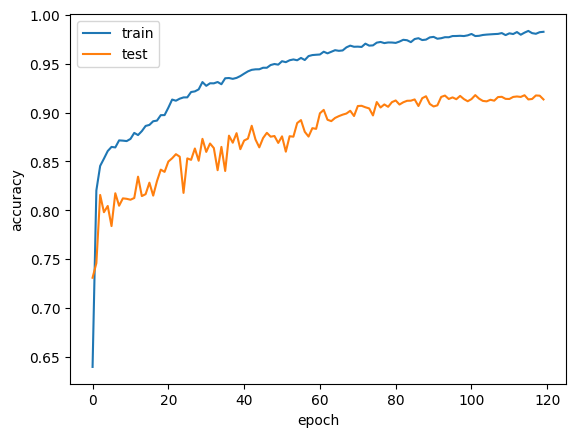

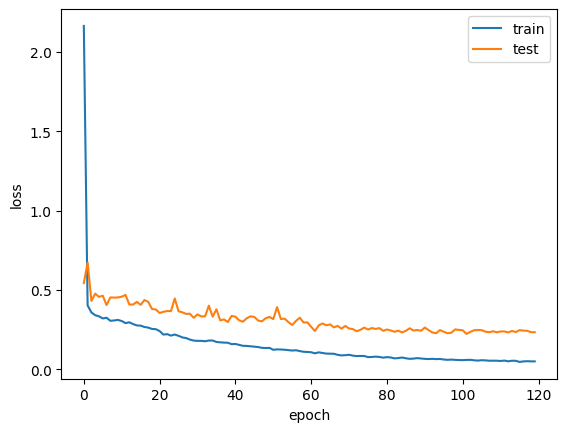

In [17]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [18]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_nCars_ReLU_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear.csv')

In [19]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.639800,0.731033,2.162741,0.543896
1,0.820322,0.745904,0.403101,0.672692
2,0.845416,0.815731,0.358875,0.431509
3,0.852873,0.798071,0.341486,0.477439
4,0.860654,0.804461,0.334558,0.456715
